# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
*   Triaxial Angular velocity from the gyroscope
*   A 561-feature vector with time and frequency domain variables
*   The activity label

More information about the features are available on the website linked above.


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import seaborn as sns, pandas as pd, numpy as np

## Question 1

Import the data and do the following:

*   Examine the data types--there are many columns, so it might be wise to use value counts.
*   Determine if the floating point values need to be scaled.
*   Determine the breakdown of each activity.
*   Encode the activity label as an integer.


In [7]:
### BEGIN SOLUTION
data = pd.read_csv("Human_Activity_Recognition_Using_Smartphones_Data.csv")

The data columns are all floats except for the activity label.


In [8]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [9]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [10]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [11]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities; they are relatively balanced.


In [12]:
data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.\
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


*A sparse matrix is a matrix in which most of the elements are zero. In contrast, a dense matrix is one in which most of the elements are non-zero. Sparse matrices are typically represented and manipulated differently from dense matrices to save memory and computational resources. Instead of storing every element of the matrix, only the non-zero elements and their corresponding indices are stored.*

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

2681    5
3228    5
999     2
1915    2
2954    0
Name: Activity, dtype: int32

## Question 2

*   Calculate the correlations between the dependent variables.
*   Create a histogram of the correlation values.
*   Identify those that are most correlated (either positively or negatively).


In [14]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting - only interested in identifying high correlation
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

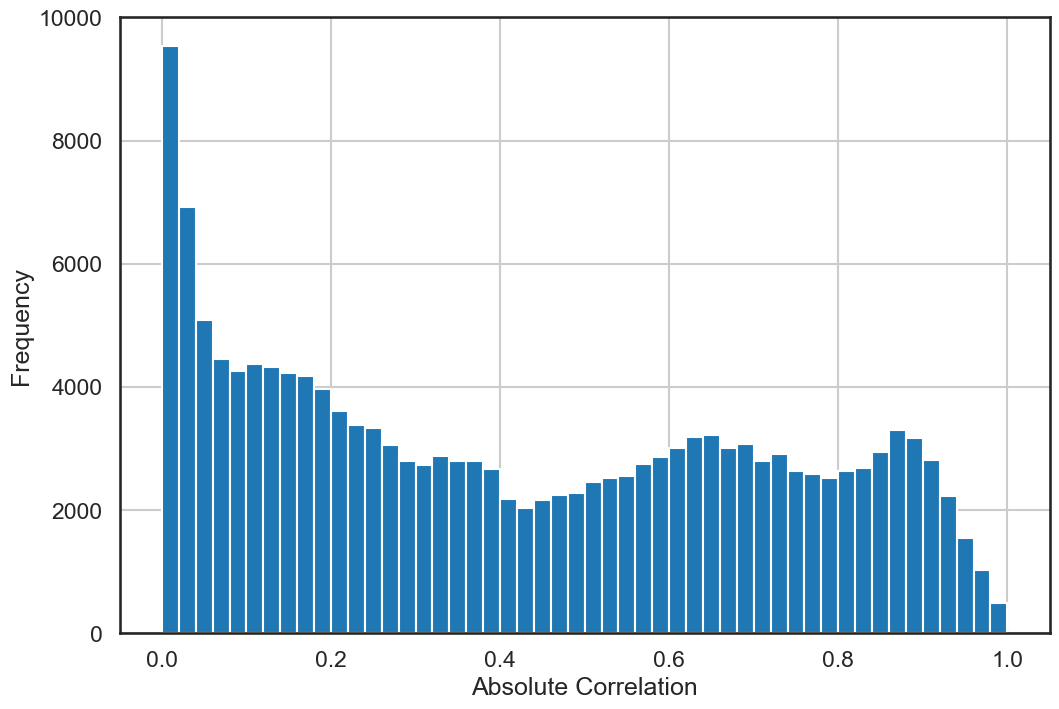

In [16]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [17]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

*   Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
*   Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [18]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

When we call normalize equals true within our value counts, it gives us our proportion rather than the actual counts, and that will allow us to compare both our Y train and our Y test to make sure they have similar distributions in this case.

In [24]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [25]:
y_test.value_counts(normalize=True)
### END SOLUTION

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

*   Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
*   Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.


In [26]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [27]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [28]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
### END SOLUTION

## Question 5

*   Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.


In [45]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
444 -0.061094 -0.004973  0.002451 -0.613662  0.627287  0.047282  0.000000   
160 -0.006053  0.282642 -0.144897 -0.067411  0.062806  0.239639  0.000000   
274  0.023332 -0.727124 -0.341293 -1.032420  0.362572  0.882923  0.000000   
284 -0.048060 -0.169294 -0.200082 -0.340025  0.553399  0.385663  0.000000   
290  0.102688  0.113181 -0.294442 -0.242480  0.011837  0.392545  0.000000   
313  0.011777  0.165731  0.271566 -0.003812  0.121893  0.149467  0.000000   
57   1.393111 -1.307188 -1.285785 -0.420852 -0.746926  1.174992  0.509500   
252 -0.030255 -0.188538  0.091225  0.246753 -0.056220 -0.298604  0.000000   
4   -0.045407 -0.034155 -0.451850  0.260237 -0.516844  0.106248  0.000000   
420 -0.005261  0.141068  0.178015 -0.158854  0.417940 -0.049662 -0.106472   

                                                             l2            \
            1         2         3         4         5         0         1   
444  0.000000  0.000000 -0.349345  0.955471 -0.106654 -0.113237 -0.045228   
160  1.002495  0.000000  0.000000  0.000000  2.242148 -0.017890  3.946128   
274 -1.617421 -0.200403 -2.564910  0.000000  2.093244  0.050475 -2.589998   
284  0.000000  0.000000  0.000000  1.700153  0.648335 -0.082157  0.622651   
290  0.180118 -0.531646  0.000000  0.043301  0.553329  0.198036  0.194667   
313  0.000000  0.304021  0.000000  0.103624  0.225096  0.002017  0.397364   
57   0.257410 -3.836352  0.000000 -0.675340  1.095060  2.534450  2.854823   
252  0.000000  0.000000  0.000000  0.000000 -0.532025 -0.056422 -1.233812   
4    0.000000 -1.366464  0.000000 -1.202981  0.246555 -0.035987  0.604884   
420  0.000000  0.000000  0.000000  0.408743 -0.009318 -0.028151  0.295836   

                                             
            2         3         4         5  
444  0.052604 -1.205513  1.037563 -0.135875  
160 -0.389078 -0.148161  0.345573  1.130051  
274 -0.453949 -2.685221  0.368715  1.823981  
284 -0.278399 -1.193702  1.286806  0.718495  
290 -0.394011 -0.772159  0.001077  0.556202  
313  0.393989 -0.105484  0.007632  0.142710  
57  -2.849627 -1.186828 -1.604962  2.456435  
252  0.200178  0.634150 -0.072264 -0.677829  
4   -0.665766  0.902878 -0.974669  0.072597  
420  0.217747 -0.469945  0.916746  0.080046

Prepare six separate plots for each of the multi-class coefficients.


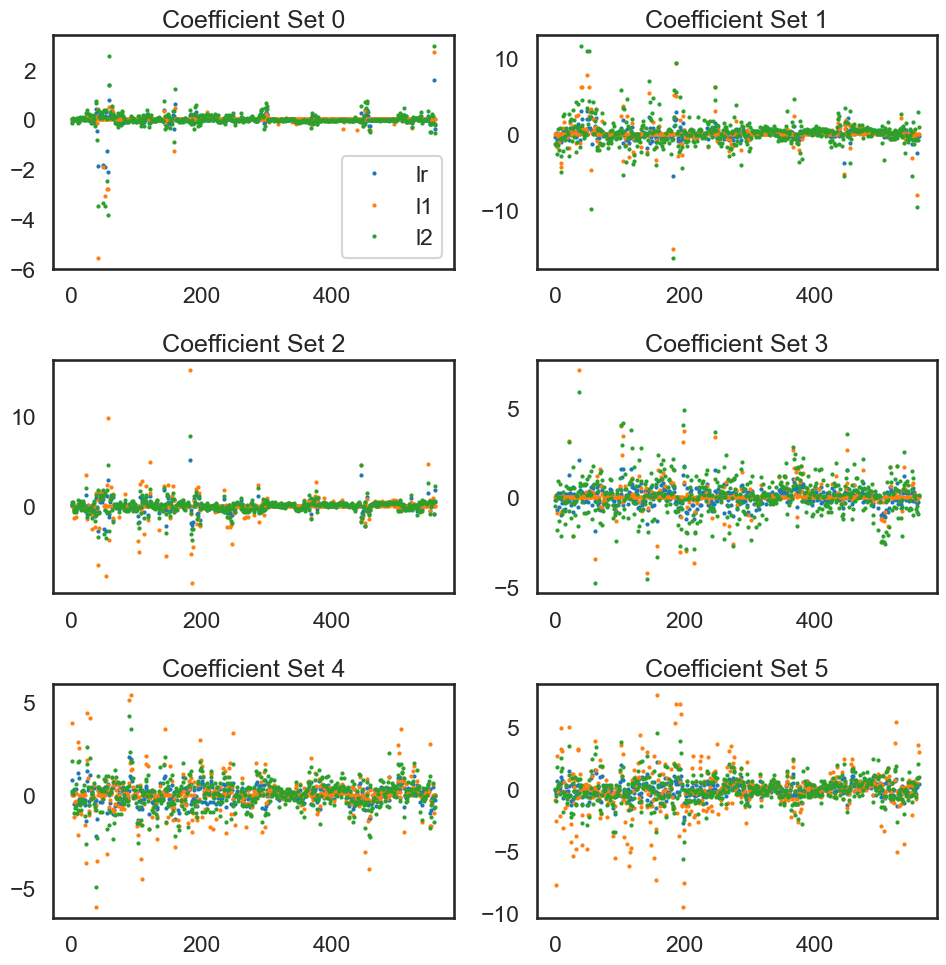

In [30]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

## Question 6

*   Predict and store the class for each model.
*   Store the probability for the predicted class for each model.


In [31]:
### BEGIN SOLUTION
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    # get a prediction for each one of our X_test indices - prediction is based on highest probability
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    # predict a proability for each one of the different classes for each X_test indices
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [32]:
y_prob.head()
### END SOLUTION

,lr,l1,l2
0,0.998939,0.998966,0.999757
1,0.988165,0.999456,0.999477
2,0.987592,0.995009,0.999670
3,0.981381,0.999186,0.994337
4,0.998277,0.999924,0.999997


## Question 7

For each model, calculate the following error metrics:

*   Accuracy
*   Precision
*   Recall
*   F-score
*   Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.


In [54]:
y_test

7743    3
969     5
3175    3
8907    1
6368    0
       ..
9629    1
2327    3
8914    1
8756    1
1470    5
Name: Activity, Length: 3090, dtype: int32

In [33]:
### BEGIN SOLUTION
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted') 
    # average='weighted' takes an average of the 3 test metric scores
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data. label_binarize here essentially performs one-hot encoding for each of our classes
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

from sklearn.metrics import `precision_recall_fscore_support as score`
* the precision, recall, fscore, support is going to output each one of those separate scores in one function.
* support is essentially a values_count and not used <br>
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score <br>
from sklearn.preprocessing import `label_binarize`
* for the ROC, we need to output probabilities
    * in order to output probabilities, we need to use the label_binarize

In [34]:
metrics
### END SOLUTION

,lr,l1,l2
precision,0.984144,0.983514,0.983824
recall,0.984142,0.983495,0.983819
fscore,0.984143,0.983492,0.983819
accuracy,0.984142,0.983495,0.983819
auc,0.990384,0.989949,0.990165


## Question 8

*   Display or plot the confusion matrix for each model.


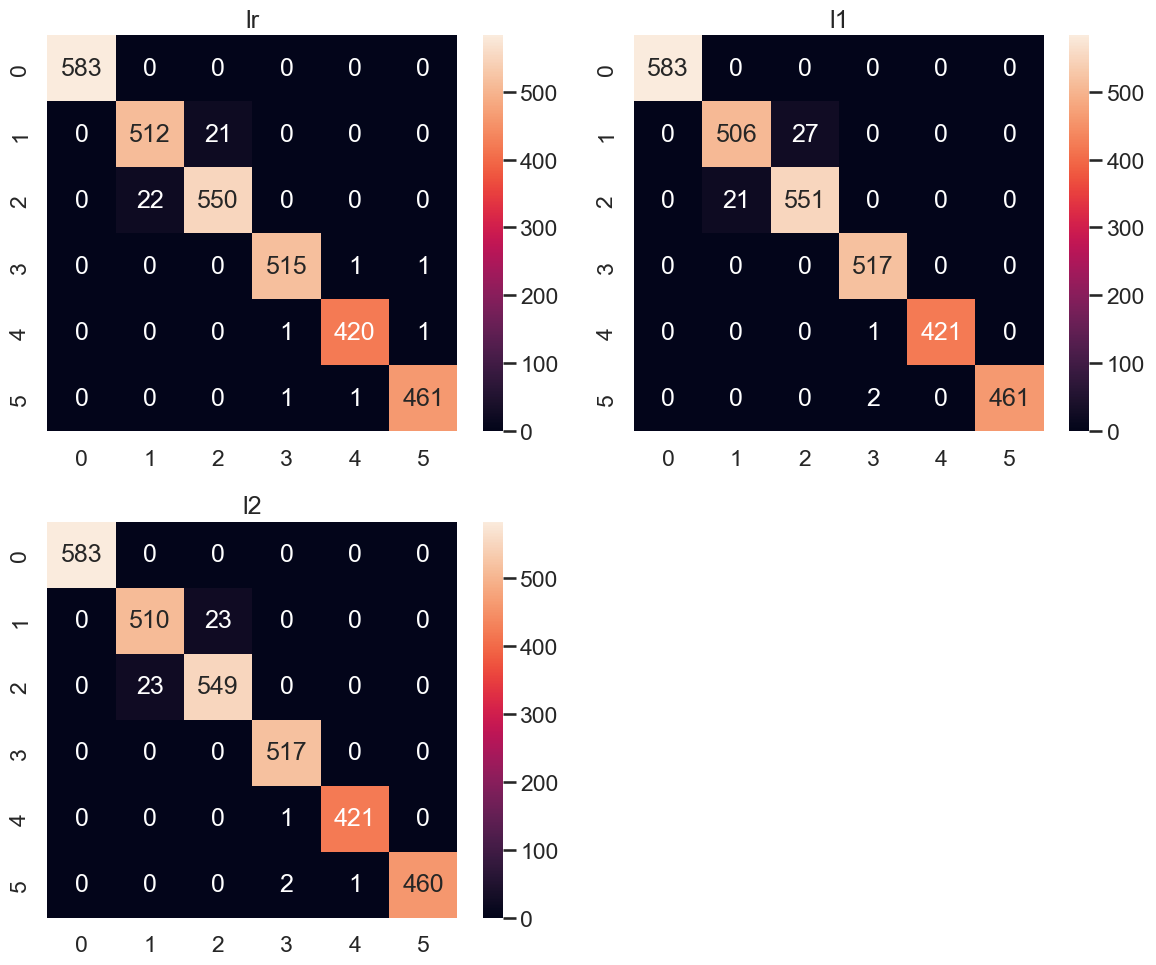

In [35]:
### BEGIN SOLUTION
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()
### END SOLUTION

***

### Machine Learning Foundation (C) 2020 IBM Corporation
